In [1]:
#The problem I encountered was that when I was performing YOLO + human segmentation on the minikinetics 50 validation,
#only half of them were being identified as having humans


#This aims to go through the CSV containing the videos that were found NOT to have humans, and for each,
# - Print out all their bounding boxes
# - Print out the bounding box that has "person"
# - Perform segmentation

In [2]:
import os
import pandas as pd
import tempfile
import shutil
import numpy as np
import torch
import sys
from PIL import Image
from PIL import ImageDraw
from IPython.display import display

os.chdir("/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics/sam2")
sys.path.insert(0, "/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics/sam2")
# print("current working direcotry", os.getcwd())
from sam2.build_sam import build_sam2_video_predictor
os.chdir("/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics")

output_root = "dataset/minikinetics50_no_human"
og_csv_path = "dataset/segmented_minikinetics50/no_human_minikinetics50_validation.csv"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device", device)


yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)

sam2_checkpoint = "/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics/sam2/checkpoints/sam2.1_hiera_large.pt"

#model_cfg, expects a config path, not an absolute path
os.chdir("/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics/sam2/sam2")
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
os.chdir("/n/fs/visualai-scr/temp_LLP/ellie/slowfast_kinetics")

Using device cuda


Using cache found in /u/ez9517/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-1 Python-3.10.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L40, 45488MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [3]:
df = pd.read_csv(og_csv_path)

# Compute indices for 8 and 32 evenly spaced frames
def sample_indices(n, total_frames):
    return [int(round(i * (total_frames - 1) / (n - 1) + 1)) for i in range(n)]

#Given a row in csv, sample indices, run yolo & video segmentation on it
#Returns
#   - segmented frames: a list of numpy arrays of shape [h, w, 3]
#   - hasPerson: a boolean
def run_yolo_and_seg(row):
    segmented_frames = [] #A list of PIL images containing all the segmented frames

    video_path = row['full_path']
    num_files = row['num_files']
    indices = sample_indices(32, num_files)
    hasPerson = False

    print("Full Path:", video_path)
    #Make a temporary directory storing video frames at certain indices
    #Make a numpy array "frames" to store the video frames at certain indices
    temp_dir = tempfile.mkdtemp()
    frames = []

    for counter, i in enumerate(indices):
        source = os.path.join(video_path, f"{i:06d}.jpg")
        dest = os.path.join(temp_dir, f"{counter:06d}.jpg")
        os.symlink(source, dest)

        img = Image.open(source).convert('RGB')  # Load as RGB
        img_np = np.array(img) #convert to np image
        frames.append(img_np)

    video_np = np.stack(frames, axis=0)

    print("shape of yolo input", video_np[0].shape)
    img0_np = video_np[0]

    results = yolo(img0_np) #get bbox for the first frame
    class_names = results.names  # This is a dict: {class_index: class_name}

    bboxes = results.xyxy[0]
    print("bboxes,", bboxes.cpu().numpy())
    person_bboxes = bboxes[bboxes[:, 5] == 0] # get bboxes for class == person only
    person_bboxes = person_bboxes[:, :4].cpu().numpy()


    print("bboxes size", bboxes.shape)

    classes = bboxes[:, 5].cpu().numpy()
    bbox_names = [class_names[cls] for cls in classes]
    print("bbox classes", bbox_names)
    #DRAW THE BOUNDING BOX
    #img0_np is your numpy image (H, W, 3)
    
    img_pil = Image.fromarray(img0_np.astype(np.uint8)).convert("RGB")
    draw = ImageDraw.Draw(img_pil)

    # Draw all bounding boxes in red
    for bbox in bboxes:
        x1, y1, x2, y2, conf, cls = bbox.tolist()
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    # Draw person bounding boxes in green
    for bbox in bboxes[bboxes[:, 5] == 0]:
        x1, y1, x2, y2, conf, cls = bbox.tolist()
        draw.rectangle([x1, y1, x2, y2], outline="green", width=3)

    display(img_pil)

    inference_state = predictor.init_state(video_path=temp_dir)

    #If a person was detected, then segment out the person
    if person_bboxes.shape[0] >= 1:
        hasPerson = True
        box = np.array(person_bboxes[0], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=0,
            obj_id=1,
            box=box,
        )

        #Go through each video frame, propogate the segmentation, calculate the binary mask
        for out_frame_idx, _, out_mask_logits in predictor.propagate_in_video(inference_state):
            binarymask = (out_mask_logits.squeeze(0).squeeze(0)) > 0.0 #binary mask, where 1 is person, 0 isnot
            binarymask = binarymask.unsqueeze(2).to(device)

            img = torch.from_numpy(video_np[out_frame_idx]).to(device)
            seg_img = binarymask * img
            seg_img_np = seg_img.cpu().numpy()
            if seg_img_np.shape[0] == 3:  # (3, H, W) -> (H, W, 3)
                seg_img_np = np.transpose(seg_img_np, (1, 2, 0))

            segmented_frames.append(seg_img_np)

    shutil.rmtree(temp_dir)
    return segmented_frames, hasPerson 

Full Path: /n/fs/visualai-scr/Data/HAT/Original Kinetics Video Frames/bowling/ZlVNRxRSQx8_000008_000018
shape of yolo input (360, 480, 3)
bboxes, []
bboxes size torch.Size([0, 6])
bbox classes []


/u/ez9517/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


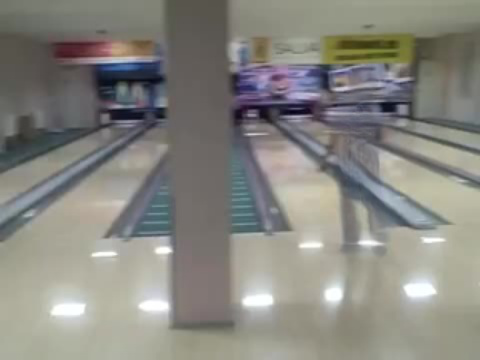

frame loading (JPEG): 100%|██████████| 32/32 [00:00<00:00, 45.29it/s]


In [132]:
#for idx, row in df.iterrows():
row = df.iloc[7]

segmented_frames, hasPerson = run_yolo_and_seg(row)

# #Save the frames into dataset/segmented_minikinetics50/train
# for i, seg_frame in enumerate(segmented_frames):
#     img = Image.fromarray(seg_frame.astype(np.uint8))
#     #display(img)

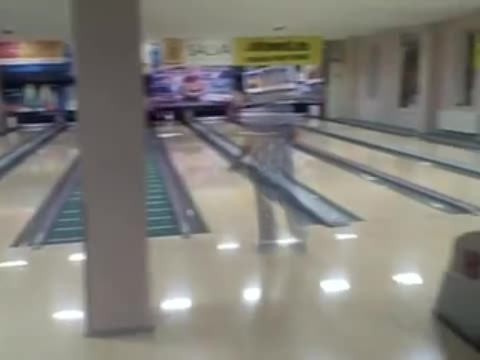

In [138]:
Image.open("/n/fs/visualai-scr/Data/HAT/E2FGVI/bowling/ZlVNRxRSQx8_000008_000018/000011.jpg")